In [1]:
import numpy as np

X = np.load('filtered_prompts_religionmean_token.npy')
X = X.reshape(-1, 12, 20)
X = X.transpose(0, 2, 1)
y = np.zeros(X.shape[0])
y[:X.shape[0]//2] = 1.0
# shape should be (# pts, 20*12)
# (# pts, 12, 768) tensor




In [2]:
X.shape

(208, 20, 12)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score

# --- Assume X and y are numpy arrays ---
# Reshape and transpose

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into train/test sets (e.g. 80% train / 20% val)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# --- Define the model ---
class ChannelWeightedMLPClassifier(nn.Module):
    def __init__(self, mlp_hidden_dim=64, mlp_output_dim=1):
        super(ChannelWeightedMLPClassifier, self).__init__()
        self.channel_weights = nn.Parameter(torch.zeros(12), requires_grad=True)
        self.mlp = nn.Sequential(
            nn.Linear(20, mlp_output_dim)
        )

    def forward(self, x):
        x_weighted = x * self.channel_weights  # (batch, 20, 12)
        x_summed = x_weighted.sum(dim=2)       # (batch, 20)
        logits = self.mlp(x_summed)            # (batch, 1)
        return logits

# --- Instantiate model, loss, optimizer ---
model = ChannelWeightedMLPClassifier()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [4]:
# --- Training loop with validation ROC AUC ---
epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X).squeeze()
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_logits = model(val_X).squeeze()
            val_probs = torch.sigmoid(val_logits)
            all_probs.extend(val_probs.cpu().numpy())
            all_labels.extend(val_y.cpu().numpy())

    val_auc = roc_auc_score(all_labels, all_probs)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val ROC AUC: {val_auc:.4f}")


Epoch 1/200 - Train Loss: 0.6922 - Val ROC AUC: 0.6077
Epoch 2/200 - Train Loss: 0.6896 - Val ROC AUC: 0.5918
Epoch 3/200 - Train Loss: 0.6852 - Val ROC AUC: 0.5873
Epoch 4/200 - Train Loss: 0.6943 - Val ROC AUC: 0.5896
Epoch 5/200 - Train Loss: 0.6912 - Val ROC AUC: 0.5941
Epoch 6/200 - Train Loss: 0.6855 - Val ROC AUC: 0.6077
Epoch 7/200 - Train Loss: 0.6839 - Val ROC AUC: 0.6077
Epoch 8/200 - Train Loss: 0.6844 - Val ROC AUC: 0.5986
Epoch 9/200 - Train Loss: 0.6830 - Val ROC AUC: 0.5918
Epoch 10/200 - Train Loss: 0.6777 - Val ROC AUC: 0.5941
Epoch 11/200 - Train Loss: 0.6664 - Val ROC AUC: 0.5964
Epoch 12/200 - Train Loss: 0.6672 - Val ROC AUC: 0.6100
Epoch 13/200 - Train Loss: 0.6561 - Val ROC AUC: 0.6145
Epoch 14/200 - Train Loss: 0.6704 - Val ROC AUC: 0.6213
Epoch 15/200 - Train Loss: 0.6688 - Val ROC AUC: 0.6372
Epoch 16/200 - Train Loss: 0.6398 - Val ROC AUC: 0.6417
Epoch 17/200 - Train Loss: 0.6407 - Val ROC AUC: 0.6485
Epoch 18/200 - Train Loss: 0.6389 - Val ROC AUC: 0.6599
E

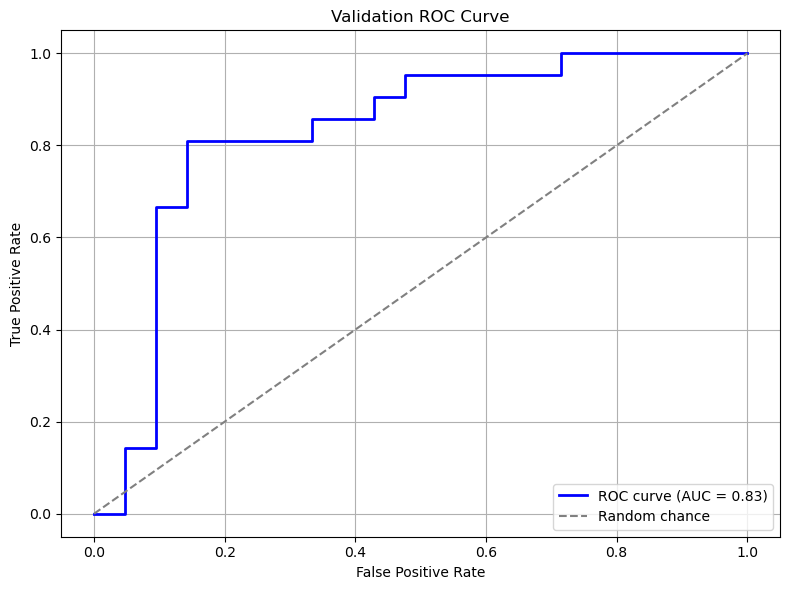

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Make sure model is in eval mode
model.eval()

# Collect all predictions and labels from validation set
all_probs = []
all_labels = []

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_logits = model(val_X).squeeze()
        val_probs = torch.sigmoid(val_logits)

        all_probs.extend(val_probs.cpu().numpy())
        all_labels.extend(val_y.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get the channel weights from the model (should be shape: (12,))
weights = model.channel_weights.detach().cpu().numpy()

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(range(len(weights)), weights, color='skyblue')
plt.xlabel("Channel Index")
plt.ylabel("Weight Value")
plt.title("Learned Channel Weights")
plt.xticks(range(len(weights)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
